In [55]:
import json
from hydra import compose, initialize
from pathlib import Path
from itertools import chain
import pandas as pd
import numpy as np
from rdkit import Chem
from IPython.display import SVG
import matplotlib.pyplot as plt
from ergochemics.draw import draw_molecule
from cgr.inference import ReactantGraph

def rc_to_nest(rc: str) -> tuple[tuple[tuple[int]]]:
    '''
    Convert string representation of reaction center to nested tuple representation.
    '''
    return tuple(
        tuple(
            tuple(
                int(aidx) for aidx in mol.split(",") if aidx != ""
            )
            for mol in side.split(";")
        )
        for side in rc.split(">>")
    )

In [56]:
with initialize(version_base=None, config_path="../configs/filepaths"):
    filepaths = compose(config_name="filepaths")

krs = Path(filepaths.data) / "raw" / "sprhea_240310_v3_mapped_no_subunits.json"
with open(krs, 'r') as f:
    krs = json.load(f)

decarb = {k: v for k,v  in krs.items() if v['min_rule'] == 'rule0024'}

with open(Path(filepaths.raw_data) / 'decarbs.json', 'w') as f:
    json.dump(decarb, f)

print(len(decarb))

86


In [57]:
embed_mat = np.load(Path(filepaths.interim_data) / 'decarb' / 'decarb_bfm.npy')
examples = pd.read_parquet(Path(filepaths.interim_data) / 'decarb' / 'subgraph_examples.parquet')

In [58]:
p1 = embed_mat.sum(axis=0) / embed_mat.shape[0]
sgids = np.argsort(p1)[::-1]
examples['reaction_center'] = examples['reaction_center'].apply(rc_to_nest)
examples.head()

,subgraph_id,rxn_id,smarts,sg_idxs,reaction_center
0,0,14,*C(=O)OCC(COP(=O)(O)OCC(N)C(=O)O)OC(*)=O>>*C(=...,[13],"(((13, 15, 17),), ((),))"
1,1,14,*C(=O)OCC(COP(=O)(O)OCC(N)C(=O)O)OC(*)=O>>*C(=...,[12],"(((13, 15, 17),), ((),))"
2,2,14,*C(=O)OCC(COP(=O)(O)OCC(N)C(=O)O)OC(*)=O>>*C(=...,[6],"(((13, 15, 17),), ((),))"
3,3,14,*C(=O)OCC(COP(=O)(O)OCC(N)C(=O)O)OC(*)=O>>*C(=...,[10],"(((13, 15, 17),), ((),))"
4,4,14,*C(=O)OCC(COP(=O)(O)OCC(N)C(=O)O)OC(*)=O>>*C(=...,[4],"(((13, 15, 17),), ((),))"


Visualize features

Subgraph id: 65
Probability: 0.40


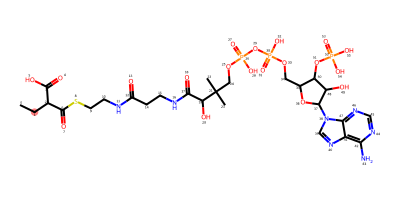

Subgraph id: 730
Probability: 0.38


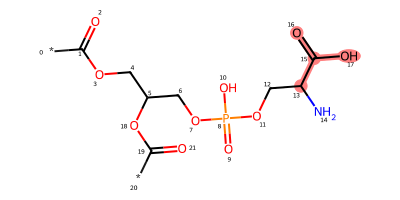

Subgraph id: 0
Probability: 0.38


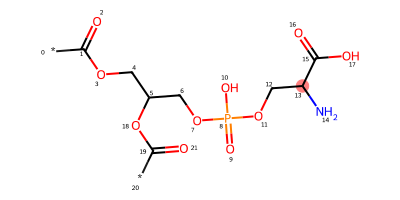

Subgraph id: 7
Probability: 0.34


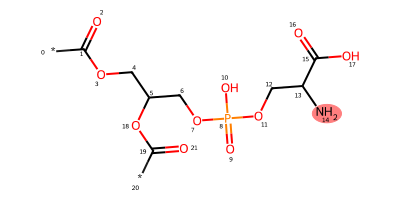

Subgraph id: 325
Probability: 0.34


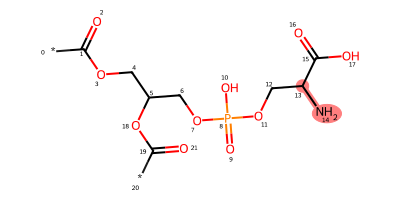

Subgraph id: 94
Probability: 0.23


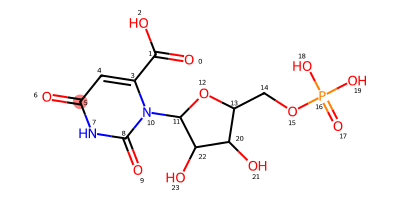

Subgraph id: 1089
Probability: 0.22


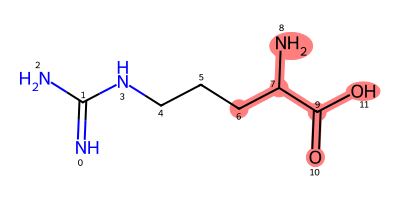

Subgraph id: 754
Probability: 0.22


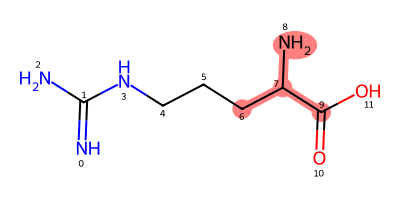

Subgraph id: 122
Probability: 0.22


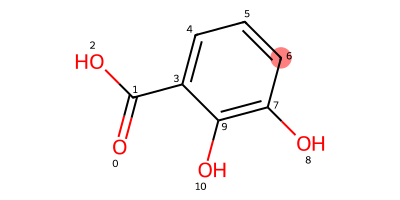

Subgraph id: 197
Probability: 0.21


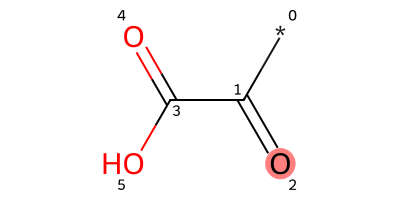

Subgraph id: 79
Probability: 0.21


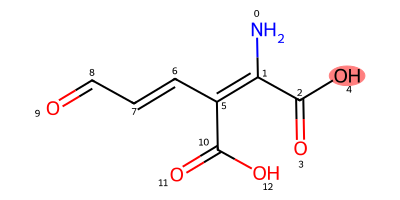

In [59]:
topk = 10
ct = 0
for sgid in sgids:
    if ct > topk:
        break

    if p1[sgid] == 1:
        continue

    ex = examples.loc[examples['subgraph_id'] == sgid].iloc[0]
    sma = ex['smarts']
    rcts = sma.split('>>')[0]
    rcts = Chem.MolFromSmiles(rcts)
    sg_idxs = ex['sg_idxs'].tolist()
    print(f"Subgraph id: {sgid}")
    print(f"Probability: {p1[sgid]:.2f}")
    display(SVG(draw_molecule(rcts, size=(400, 200), highlight_atoms=sg_idxs, draw_options={"addAtomIndices": True})))
    ct += 1
    

Subgraph id: 730
Probability: 0.38


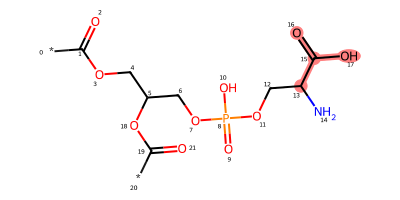

Subgraph id: 730
Probability: 0.38


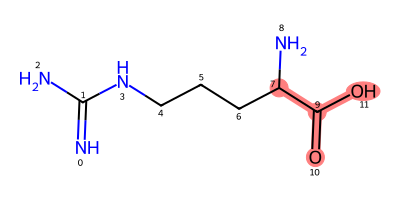

Subgraph id: 730
Probability: 0.38


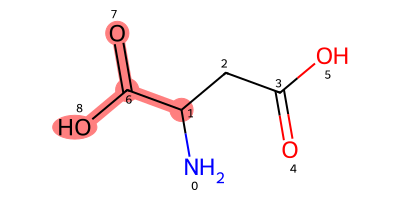

Subgraph id: 730
Probability: 0.38


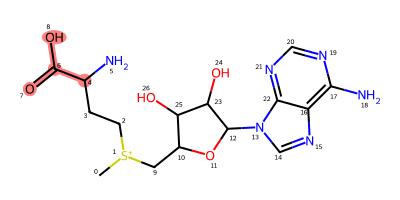

Subgraph id: 730
Probability: 0.38


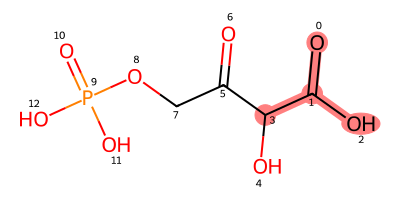

Subgraph id: 730
Probability: 0.38


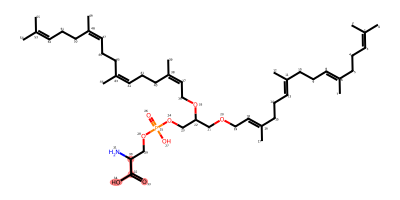

Subgraph id: 730
Probability: 0.38


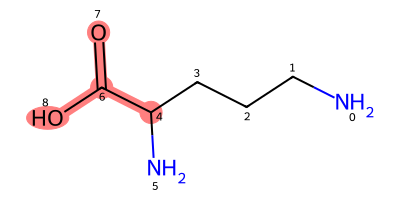

Subgraph id: 730
Probability: 0.38


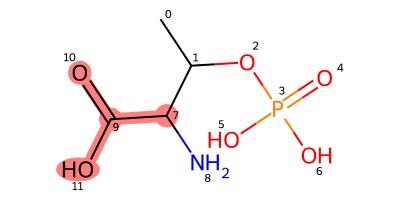

Subgraph id: 730
Probability: 0.38


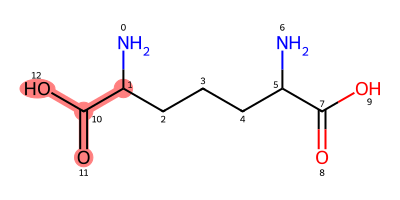

Subgraph id: 730
Probability: 0.38


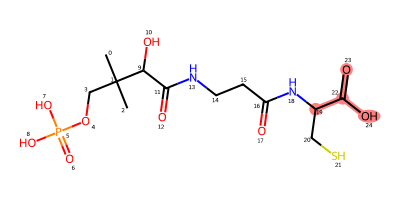

Subgraph id: 730
Probability: 0.38


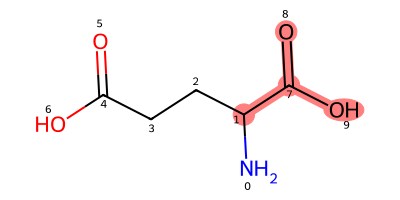

In [60]:
sgid = 730
ct = 0
for i, ex in examples.loc[examples['subgraph_id'] == sgid].iterrows():
    if ct > 10:
        break

    sma = ex['smarts']
    rcts = sma.split('>>')[0]
    rcts = Chem.MolFromSmiles(rcts)
    sg_idxs = ex['sg_idxs'].tolist()
    print(f"Subgraph id: {sgid}")
    print(f"Probability: {p1[sgid]:.2f}")
    display(SVG(draw_molecule(rcts, size=(400, 200), highlight_atoms=sg_idxs, draw_options={"addAtomIndices": True})))
    
    ct +=1

PCA

In [ ]:
topk = 5
n_samples = len(decarb)

p1_init = embed_mat.sum(axis=0) / len(embed_mat)
accepted_ftids_init = accepted.index.to_numpy()
constants = {int(elt) for elt in np.argwhere(p1_init == 1)}
Sf = np.matmul(embed_mat.T, embed_mat) # ft x ft similarity matrix

fts = []
h_mention = []
while True:
    _most_probable = np.argsort(p1_init[accepted_ftids_init])[::-1]
    most_probable = np.array([int(elt) for elt in accepted_ftids_init[_most_probable]])

    if len(fts) == 0:
        fts.append(most_probable[0])
        h_mention.append(most_probable[1])
    else:
        ortho_mask = Sf[np.array(fts)][:, most_probable].sum(axis=0) == 0
        mp_ortho = most_probable[ortho_mask]
        options = list(zip(mp_ortho[:topk], p1_init[mp_ortho][:topk]))
        options = [(int(elt[0]), float(elt[1])) for elt in options]
        print(f"Options: {options}")

        if len(options) == 0:
            print("Ran out of orthogonal subgraphs")
            break
        
        elif p1_init[mp_ortho[0]] <= (1 / n_samples):
            print("Hit n=1 feature")
            break
        
        fts.append(mp_ortho[0])
        h_mention.append(mp_ortho[1])


print(len(fts))

/tmp/ipykernel_32308/273470416.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  constants = {int(elt) for elt in np.argwhere(p1_init == 1)}


Options: [(2659, 0.20930232558139536), (1873, 0.1744186046511628), (1401, 0.1511627906976744), (454, 0.11627906976744186), (2980, 0.11627906976744186)]
Options: [(1401, 0.1511627906976744), (454, 0.11627906976744186), (2980, 0.11627906976744186), (504, 0.08139534883720931), (3523, 0.06976744186046512)]
Options: [(454, 0.11627906976744186), (2980, 0.11627906976744186), (3523, 0.06976744186046512), (766, 0.05813953488372093), (2036, 0.046511627906976744)]
Options: [(1019, 0.03488372093023256), (3782, 0.03488372093023256), (802, 0.03488372093023256), (593, 0.03488372093023256), (1939, 0.03488372093023256)]
Options: [(3782, 0.03488372093023256), (802, 0.03488372093023256), (593, 0.03488372093023256), (1939, 0.03488372093023256), (2211, 0.03488372093023256)]
Options: [(3566, 0.011627906976744186), (3571, 0.011627906976744186), (63, 0.011627906976744186), (3749, 0.011627906976744186), (3748, 0.011627906976744186)]
Hit n=1 feature
6


In [ ]:
remaining_rxns_mask = (embed_mat[:, fts].sum(axis=1)) == 0
remaining_rxns = embeddings.loc[remaining_rxns_mask, 'sample_id'].to_list()
len(remaining_rxns)

10

Feature id: 71
Fraction: 0.3372
Cumulative fraction: 0.3372


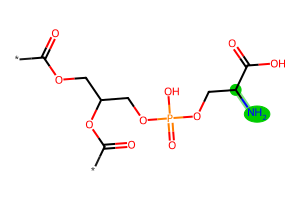

--------------------------------------------------
Feature id: 2659
Fraction: 0.2093
Cumulative fraction: 0.5465


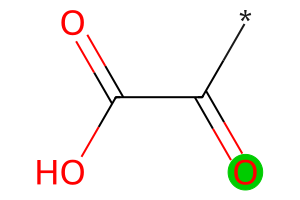

--------------------------------------------------
Feature id: 1401
Fraction: 0.1512
Cumulative fraction: 0.6977


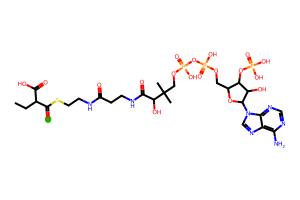

--------------------------------------------------
Feature id: 454
Fraction: 0.1163
Cumulative fraction: 0.8140


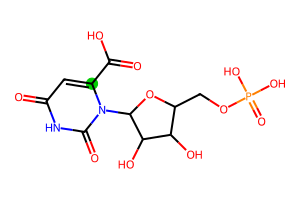

--------------------------------------------------
Feature id: 1019
Fraction: 0.0349
Cumulative fraction: 0.8488


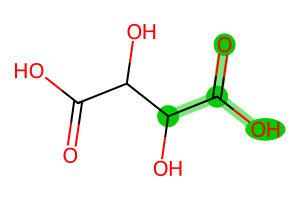

--------------------------------------------------
Feature id: 3782
Fraction: 0.0349
Cumulative fraction: 0.8837


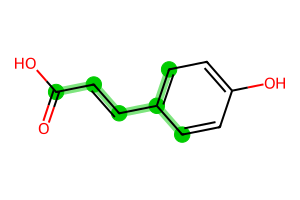

--------------------------------------------------


In [ ]:
cum_fraction = 0
n_egs = 1
highlight_rc = False
highlight_color = (0, 0.8, 0, 0.5)
frac_stack = []

for ftid in fts:
    frac = accepted.loc[ftid, 'p1']
    frac_stack.append(frac)
    cum_fraction += frac
    print(f"Feature id: {ftid}")
    print(f"Fraction: {frac:.4f}")
    print(f"Cumulative fraction: {cum_fraction:.4f}")
    for i in range(n_egs):
        if i >= len(examples.loc[[ftid]]):
            break
        
        mol = examples.loc[[ftid]].iloc[[i]]['mol'].values[0]
        sub_idxs = examples.loc[[ftid]].iloc[[i]]['sub_idxs'].values[0]
        super_rc = examples.loc[[ftid]].iloc[[i]]['super_rc'].values[0]

        if highlight_rc:
            display(SVG(draw_molecule(mol, size=(300, 200), highlight_atoms=chain(sub_idxs, super_rc), draw_options={'setHighlightColour':highlight_color})))
        else:
            display(SVG(draw_molecule(mol, size=(300, 200), highlight_atoms=sub_idxs, draw_options={'setHighlightColour':highlight_color})))
    
    print('-' * 50)

frac_stack.append(1 - sum(frac_stack))

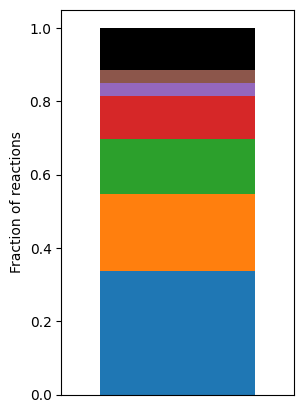

In [ ]:
fig, ax = plt.subplots(figsize=(3, 5))
bottom = 0
width = 0.4
x = 0
for i, frac in enumerate(frac_stack):
    if i == len(frac_stack) - 1:
        ax.bar(x=x, height=frac, width=width, bottom=bottom, color='black')
    else:
        ax.bar(x=x, height=frac, width=width, bottom=bottom)
    bottom += frac

ax.set_xlim(-0.3, 0.3)
ax.set_xticks([])
ax.set_ylabel("Fraction of reactions")

plt.show()

Feature id: 2997


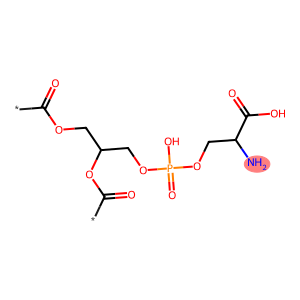

--------------------------------------------------
Feature id: 1873


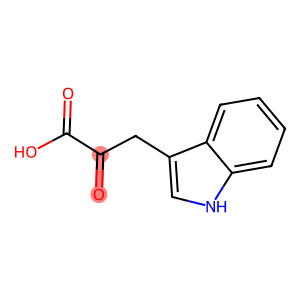

--------------------------------------------------
Feature id: 2980


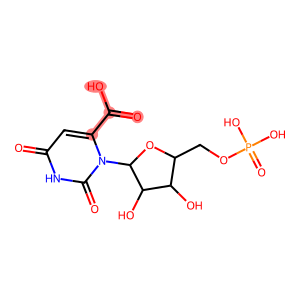

--------------------------------------------------
Feature id: 802


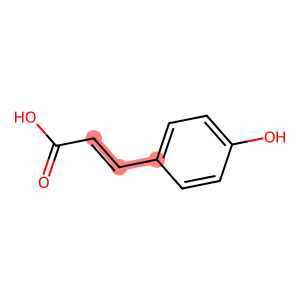

--------------------------------------------------


In [ ]:
for ftid in h_mention:
    if ftid in fts:
        continue
    
    mol = examples.loc[[ftid]].iloc[[0]]['mol'].values[0]
    sub_idxs = examples.loc[[ftid]].iloc[[0]]['sub_idxs'].values[0]
    frac = accepted.loc[ftid, 'p1']
    cum_fraction += frac
    print(f"Feature id: {ftid}")
    display(SVG(draw_molecule(mol, size=(300, 300), highlight_atoms=tuple(sub_idxs))))
    
    print('-' * 50)

Sample id: 121


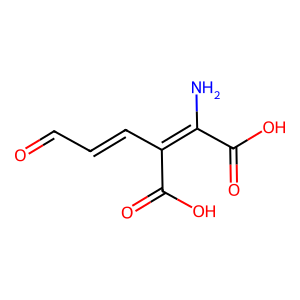

--------------------------------------------------
Sample id: 16361


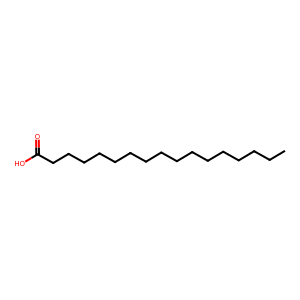

--------------------------------------------------
Sample id: 17237


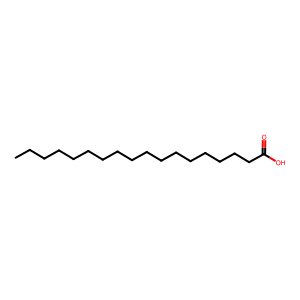

--------------------------------------------------
Sample id: 17305


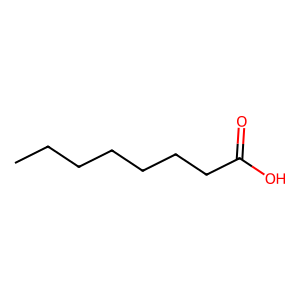

--------------------------------------------------
Sample id: 18112


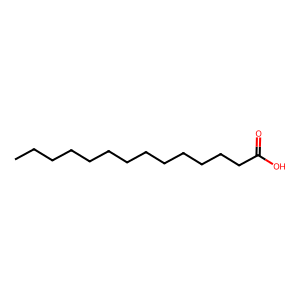

--------------------------------------------------
Sample id: 19342


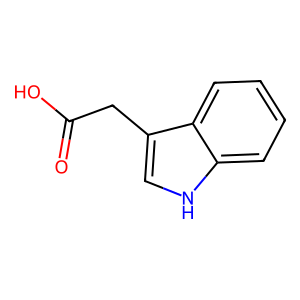

--------------------------------------------------
Sample id: 4235


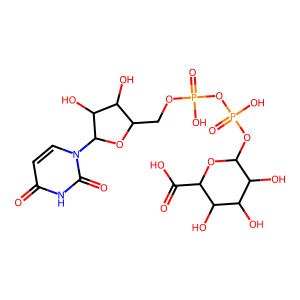

--------------------------------------------------
Sample id: 5907


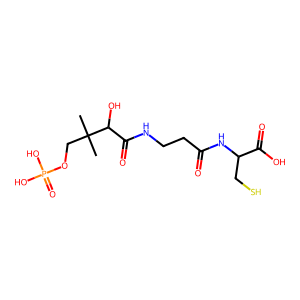

--------------------------------------------------
Sample id: 6613


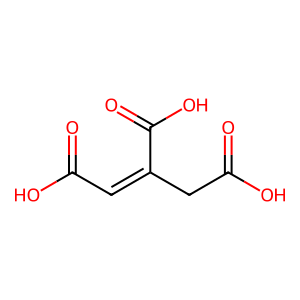

--------------------------------------------------
Sample id: 9599


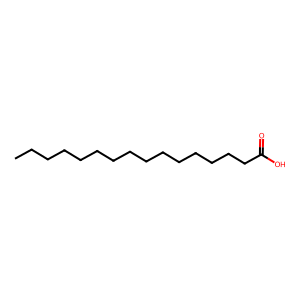

--------------------------------------------------


In [ ]:
for sample_id in remaining_rxns:
    
    mol = examples.loc[examples['sample_id'] == sample_id].iloc[[0]]['mol'].values[0]
    # sub_idxs = examples.loc[examples['sample_id'] == sample_id].iloc[[0]]['sub_idxs'].values[0]
    cum_fraction += frac
    print(f"Sample id: {sample_id}")
    display(SVG(draw_molecule(mol, size=(300, 300))))
    
    print('-' * 50)